In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

# Загрукза данных

C:\Users\makso\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


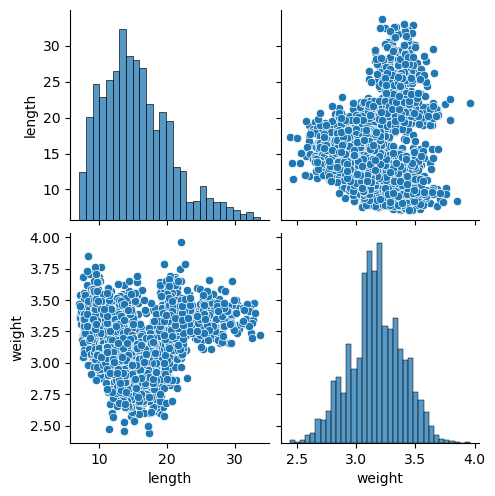

In [22]:
data_fish = pd.read_csv("fish_data.csv")
data_fish = data_fish.drop(['w_l_ratio'], axis=1)
sns.pairplot(data_fish)

In [23]:
X_fish = data_fish.drop(['species'], axis=1)
y_fish = data_fish['species']

C:\Users\makso\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


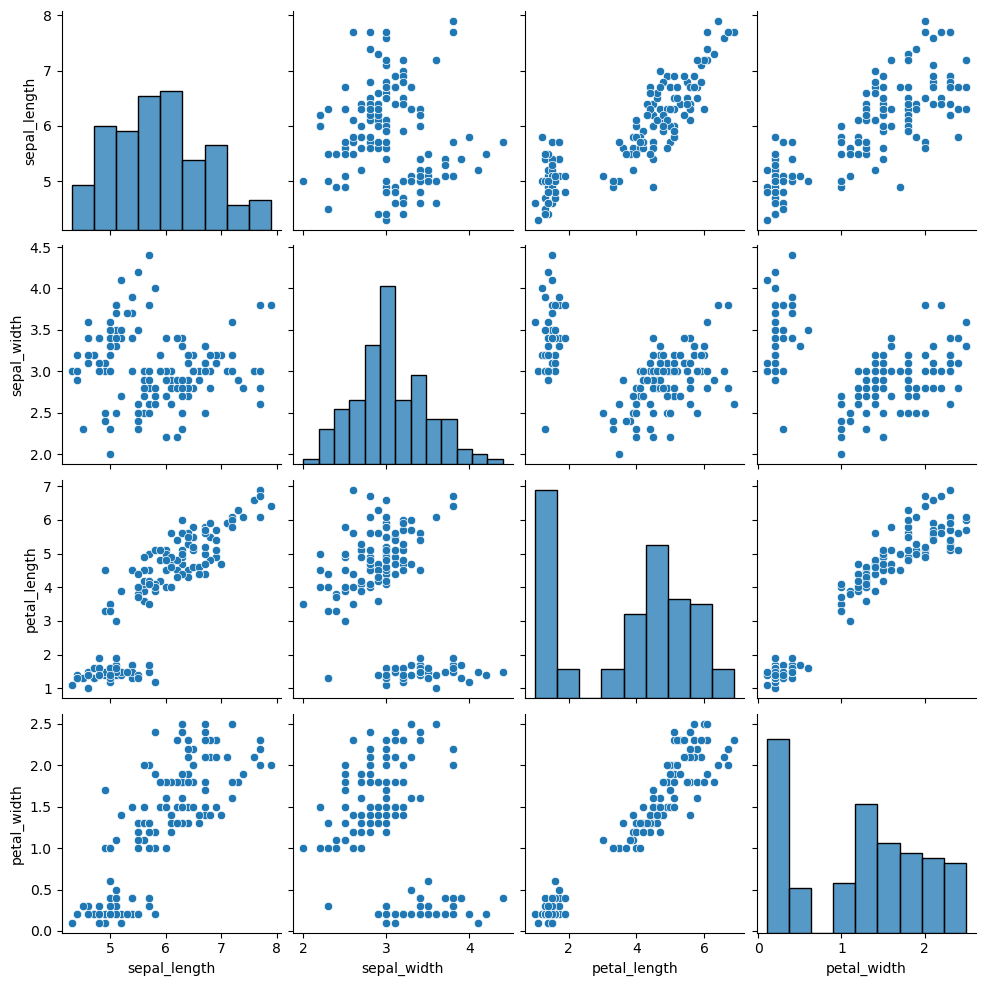

In [24]:
data_iris = pd.read_csv("iris.csv")
data_iris = data_iris.drop_duplicates()
sns.pairplot(data_iris)

In [25]:
X_iris = data_iris.drop(['species'], axis=1)
y_iris = data_iris['species']

In [26]:
x, X_fish = train_test_split(X_fish, test_size=0.2, random_state=42)

In [27]:
# преобразование данных входа в необходимый вид
cluster_df_fish = []

for idx_1, row_1 in X_fish.iterrows():
    cluster_df_fish.append(tuple(row_1))

cluster_df_iris = []

for idx_2, row_2 in X_iris.iterrows():
    cluster_df_iris.append(tuple(row_2))

# Метрики

In [28]:
# среднее внутрикластерное расстояние
def inner_clus(clusters, list_num):
    list_dist = []
    for i in list_num:
        cluster = clusters[clusters['flag'] == i]
        sum_ = 0
        for idx, row in cluster.iterrows():
            for jdx, row_ in cluster.iterrows():
                if idx < jdx:
                    sum_ += np.linalg.norm(np.array(list(row)) - np.array(list(row_)))
        list_dist.append(sum_ / len(cluster))
    
    return sum(list_dist)

In [29]:
# среднее межкластерное расстояние
def outer_clus(clusters, list_num):
    list_dist = []
    for i in list_num:
        cluster = clusters[clusters['flag'] == i]
        sum_ = 0
        for idx, row in cluster.iterrows():
            for jdx, row_ in clusters[clusters['flag'] != i].iterrows():
                sum_ += np.linalg.norm(np.array(list(row)) - np.array(list(row_)))
        
        list_dist.append(sum_ / len(cluster))
    
    return sum(list_dist)

# Иерархия

In [30]:
# иерархическая кластеризация
def hier(cluster_, clast_num):
    clusters = [cluster_]
    distances = dict()

    for i in range(1, len(cluster_) + 1):
        min_dist = 10 ** 9
        if len(clusters[-1]) == clast_num:
            return clusters[-1], distances

        if i == 1:
            for k in range(len(clusters[i - 1])):
                for j in range(len(clusters[i - 1])):
                    if k != j:
                        dist = np.linalg.norm(np.array(clusters[i - 1][k]) - np.array(clusters[i - 1][j]))
                        distances[(clusters[i - 1][k], clusters[i - 1][j])] = dist

                        if dist < min_dist:
                            min_dist = dist
                            min_1 = clusters[i - 1][k]
                            min_2 = clusters[i - 1][j]
        else:
            for key, value in distances.items():
                if value < min_dist:
                    min_dist = value
                    min_1 = key[0]
                    min_2 = key[1]

        new_cluster = (min_1, min_2)
        cluster_copy = clusters[-1].copy()
        cluster_copy.remove(min_1)
        cluster_copy.remove(min_2)
        clusters.append([*cluster_copy])

        for s in clusters[-1]:
            v_s = distances.get((s, new_cluster[0]))
            if v_s is None:
                v_s = distances.get((new_cluster[0], s))
            
            u_s = distances.get((s, new_cluster[1]))
            if u_s is None:
                u_s = distances.get((new_cluster[1], s))
            
            distances[(new_cluster, s)] = 0.5 * (v_s + u_s + abs(v_s - u_s))
            
        keys_ = []
        for key_ in distances.keys():
            if min_2 in key_ or min_1 in key_:
                keys_.append(key_)

        for k_ in keys_:
            del distances[k_]

        clusters[-1].append(new_cluster)

# постобработка выхода иерархической кластеризации
def post_process(cl):
    i = 0
    list_ = []
    for symb in str(cl):
        if symb == '(' and str(cl)[i+1] in ['1', '2', '3', '4', '5', '6', '7', '8', '9']:
            list_.append(str(cl)[i-1: str(cl)[i-1:].find(')')+i].replace('(', '').replace(')', ''))
        else:
            pass
        i += 1
    return list_
                               
def create_str(list_1):
    str_to_df = []
    for i_ in list_1:
        str_to_df_ = []
        for j_ in i_.split(','):
            str_to_df_.append(float(j_))   
        str_to_df.append(str_to_df_)
    return str_to_df

## Кластеризация рыб

***Ручной алгоритм***

In [31]:
# кластеризация
time_ = datetime.datetime.now()
cl, di = hier(cluster_df_fish, 9)
time__ = datetime.datetime.now()
time_ier_hand_fish_ = time__ - time_

# обработка выхода
df_ier_fish_ = X_fish.copy().head(0)
df_ier_fish_['flag'] = []

row_num = 0

for _ in range(len(cl)):
    list_ = post_process(cl[_])
    str_ = create_str(list_)
    for s_ in str_:
        s_.append(_)
        df_ier_fish_.loc[row_num] = s_
        row_num += 1

# точность прописанного алгоритма иерархической кластеризации

inner_ier_hand_fish_ = inner_clus(df_ier_fish_, list(df_ier_fish_['flag'].unique()))
outer_ier_hand_fish_ = outer_clus(df_ier_fish_, list(df_ier_fish_['flag'].unique()))

print(f'Внутрикластерное расстояние у иерархического алгоритма (вручную): {inner_ier_hand_fish_}',
      f'Межкластерное расстояние у иерархического алгоритма (вручную): {outer_ier_hand_fish_}',
      f'Время работы у иерархического алгоритма (вручную): {time_ier_hand_fish_.seconds * 10**6}',
      sep='\n')

Внутрикластерное расстояние у иерархического алгоритма (вручную): 218.5226006937164
Межкластерное расстояние у иерархического алгоритма (вручную): 35862.3640085021
Время работы у иерархического алгоритма (вручную): 12000000


***Автоматический алгоритм***

In [32]:
# кластеризация
time_ = datetime.datetime.now()
clustering = AgglomerativeClustering(n_clusters=9, linkage='complete').fit(X_fish)
time__ = datetime.datetime.now()
time_ier_lib_fish = time__ - time_

# обработка выхода 
df_ier_fish = X_fish.copy()
df_ier_fish['flag'] = list(clustering.labels_)

# оценка точности
inner_ier_lib_fish = inner_clus(df_ier_fish, list(df_ier_fish['flag'].unique()))
outer_ier_lib_fish = outer_clus(df_ier_fish, list(df_ier_fish['flag'].unique()))

print(f'Внутрикластерное расстояние у иерархического алгоритма (библиотека): {inner_ier_lib_fish}',
      f'Межкластерное расстояние у иерархического алгоритма (библиотека): {outer_ier_lib_fish}',
      f'Время работы у иерархического алгоритма (библиотека): {time_ier_lib_fish.microseconds}',
      sep='\n')

Внутрикластерное расстояние у иерархического алгоритма (библиотека): 218.5226006937167
Межкластерное расстояние у иерархического алгоритма (библиотека): 36260.265967655214
Время работы у иерархического алгоритма (библиотека): 12313


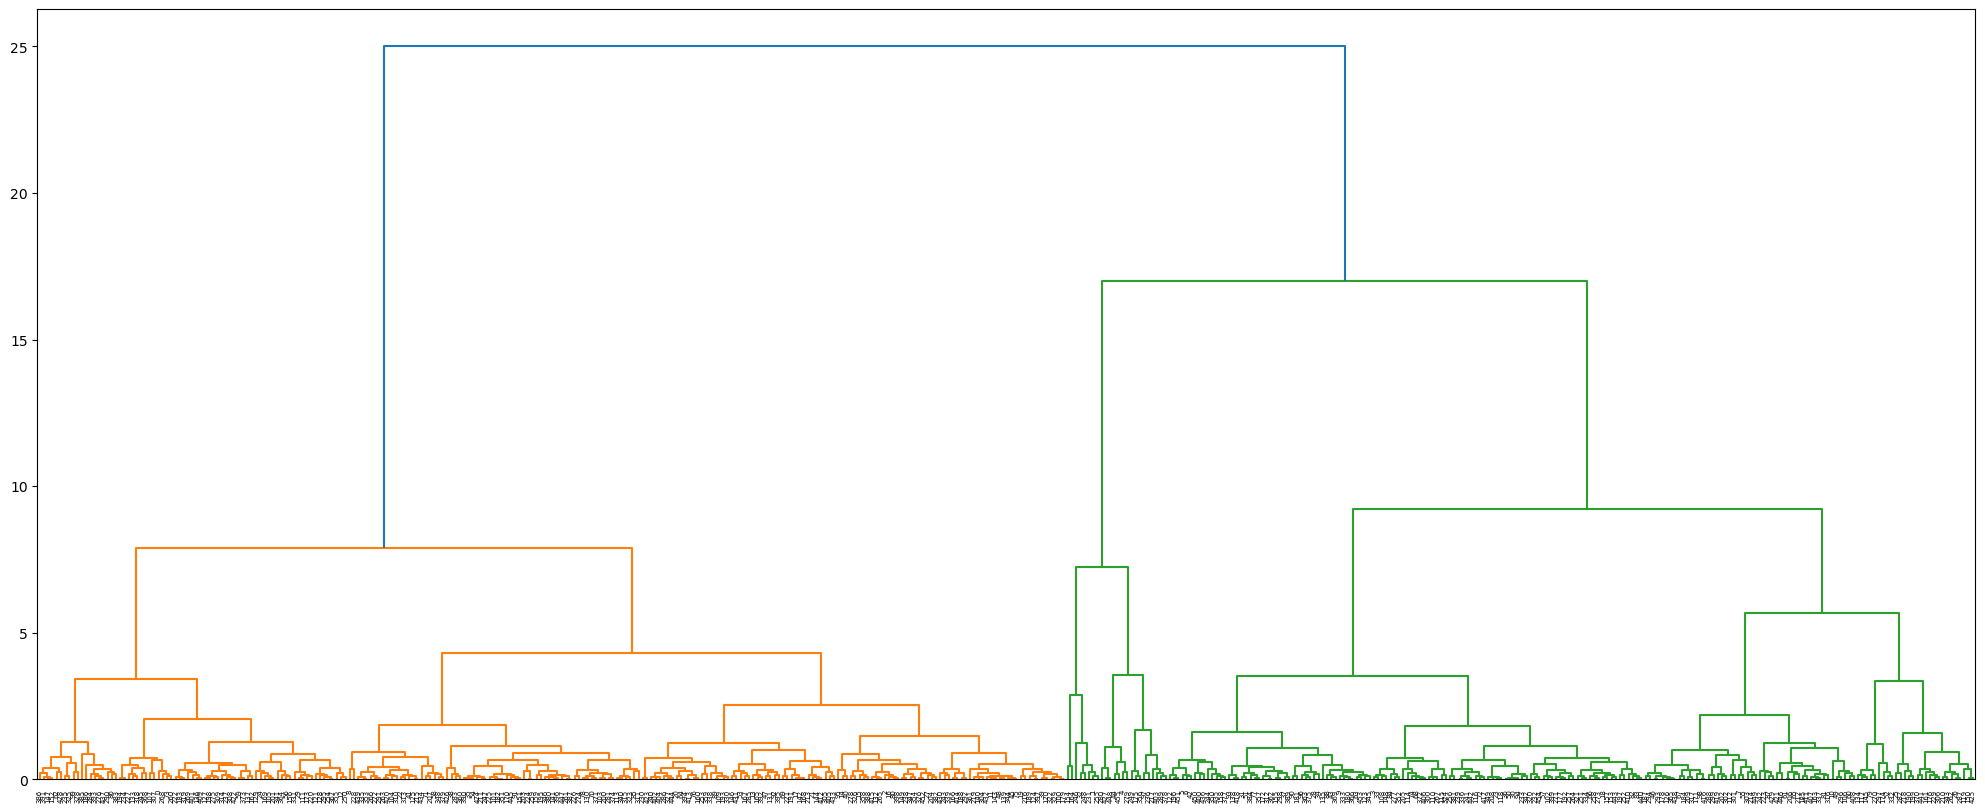

In [33]:
Z = linkage(X_fish, 'complete')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

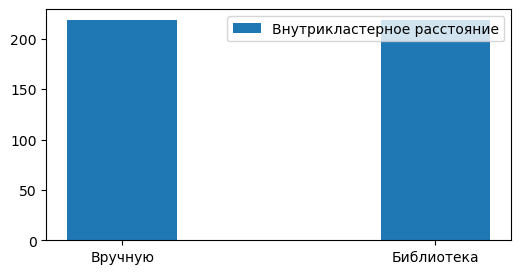

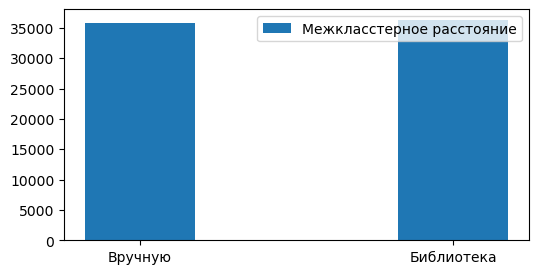

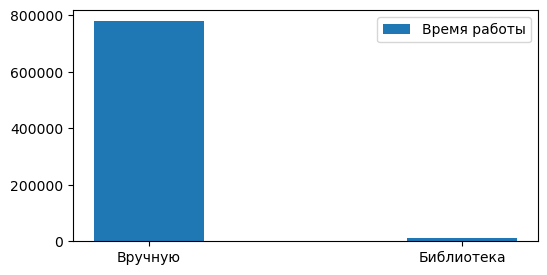

In [34]:
fig, ax = plt.subplots(figsize=(6,3))
rects1 = ax.bar(['Вручную', 'Библиотека'], [inner_ier_hand_fish_, inner_ier_lib_fish], 0.35, label='Внутрикластерное расстояние')
ax.set_xticks(['Вручную', 'Библиотека'])
ax.legend()

fig, ax = plt.subplots(figsize=(6,3))

rects2 = ax.bar(['Вручную', 'Библиотека'], [outer_ier_hand_fish_, outer_ier_lib_fish], 0.35, label='Межкласстерное расстояние')
ax.set_xticks(['Вручную', 'Библиотека'])
ax.legend()

fig, ax = plt.subplots(figsize=(6,3))
rects3 = ax.bar(['Вручную', 'Библиотека'], [time_ier_hand_fish_.microseconds, time_ier_lib_fish.microseconds], 0.35, label='Время работы')
ax.set_xticks(['Вручную', 'Библиотека'])
ax.legend()

C:\Users\makso\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\makso\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


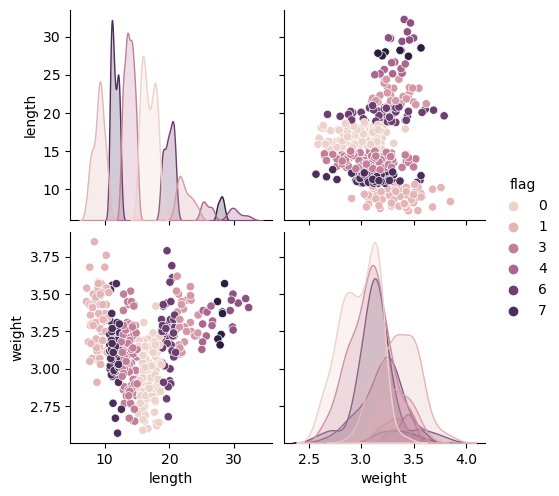

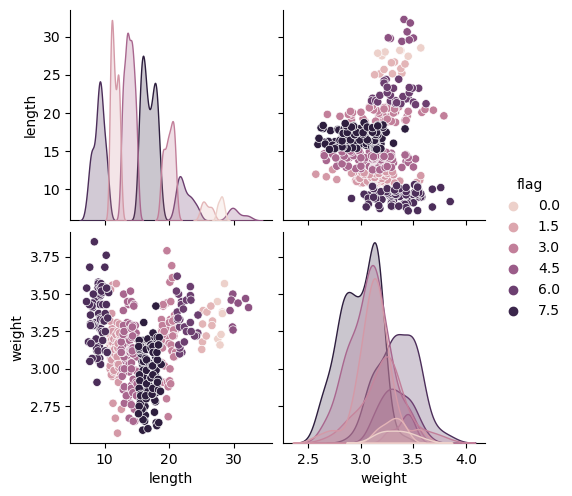

In [35]:
sns.pairplot(df_ier_fish, hue='flag')
sns.pairplot(df_ier_fish_, hue='flag')

## Кластеризация ириса

***Ручная кластеризация***

In [36]:
# кластеризация
time_ = datetime.datetime.now()
cl, di = hier(cluster_df_iris, 4)
time__ = datetime.datetime.now()
time_ier_hand_iris_ = time__ - time_

# обработка выхода
df_ier_iris_ = X_iris.copy().head(0)
df_ier_iris_['flag'] = []

row_num = 0

for _ in range(len(cl)):
    list_ = post_process(cl[_])
    str_ = create_str(list_)
    for s_ in str_:
        s_.append(_)
        df_ier_iris_.loc[row_num] = s_
        row_num += 1

# точность прописанного алгоритма иерархической кластеризации

inner_ier_hand_iris_ = inner_clus(df_ier_iris_, list(df_ier_iris_['flag'].unique()))
outer_ier_hand_iris_ = outer_clus(df_ier_iris_, list(df_ier_iris_['flag'].unique()))

print(f'Внутрикластерное расстояние у иерархического алгоритма (вручную): {inner_ier_hand_iris_}',
      f'Межкластерное расстояние у иерархического алгоритма (вручную): {outer_ier_hand_iris_}',
      f'Время работы у иерархического алгоритма (вручную): {time_ier_hand_iris_.microseconds}',
      sep='\n')

Внутрикластерное расстояние у иерархического алгоритма (вручную): 59.547886613492985
Межкластерное расстояние у иерархического алгоритма (вручную): 1631.7699611589878
Время работы у иерархического алгоритма (вручную): 656393


***Автоматическая кластеризация***

In [37]:
# кластеризация
time_ = datetime.datetime.now()
clustering = AgglomerativeClustering(n_clusters=4, linkage='complete').fit(X_iris)
time__ = datetime.datetime.now()
time_ier_lib_iris = time__ - time_

# обработка выхода 
df_ier_iris = X_iris.copy()
df_ier_iris['flag'] = list(clustering.labels_)

# оценка точности
inner_ier_lib_iris = inner_clus(df_ier_iris, list(df_ier_iris['flag'].unique()))
outer_ier_lib_iris = outer_clus(df_ier_iris, list(df_ier_iris['flag'].unique()))

print(f'Внутрикластерное расстояние у иерархического алгоритма (библиотека): {inner_ier_lib_iris}',
      f'Межкластерное расстояние у иерархического алгоритма (библиотека): {outer_ier_lib_iris}',
      f'Время работы у иерархического алгоритма (библиотека): {time_ier_lib_iris.microseconds}',
      sep='\n')

Внутрикластерное расстояние у иерархического алгоритма (библиотека): 59.54788661349302
Межкластерное расстояние у иерархического алгоритма (библиотека): 1631.769961158987
Время работы у иерархического алгоритма (библиотека): 6624


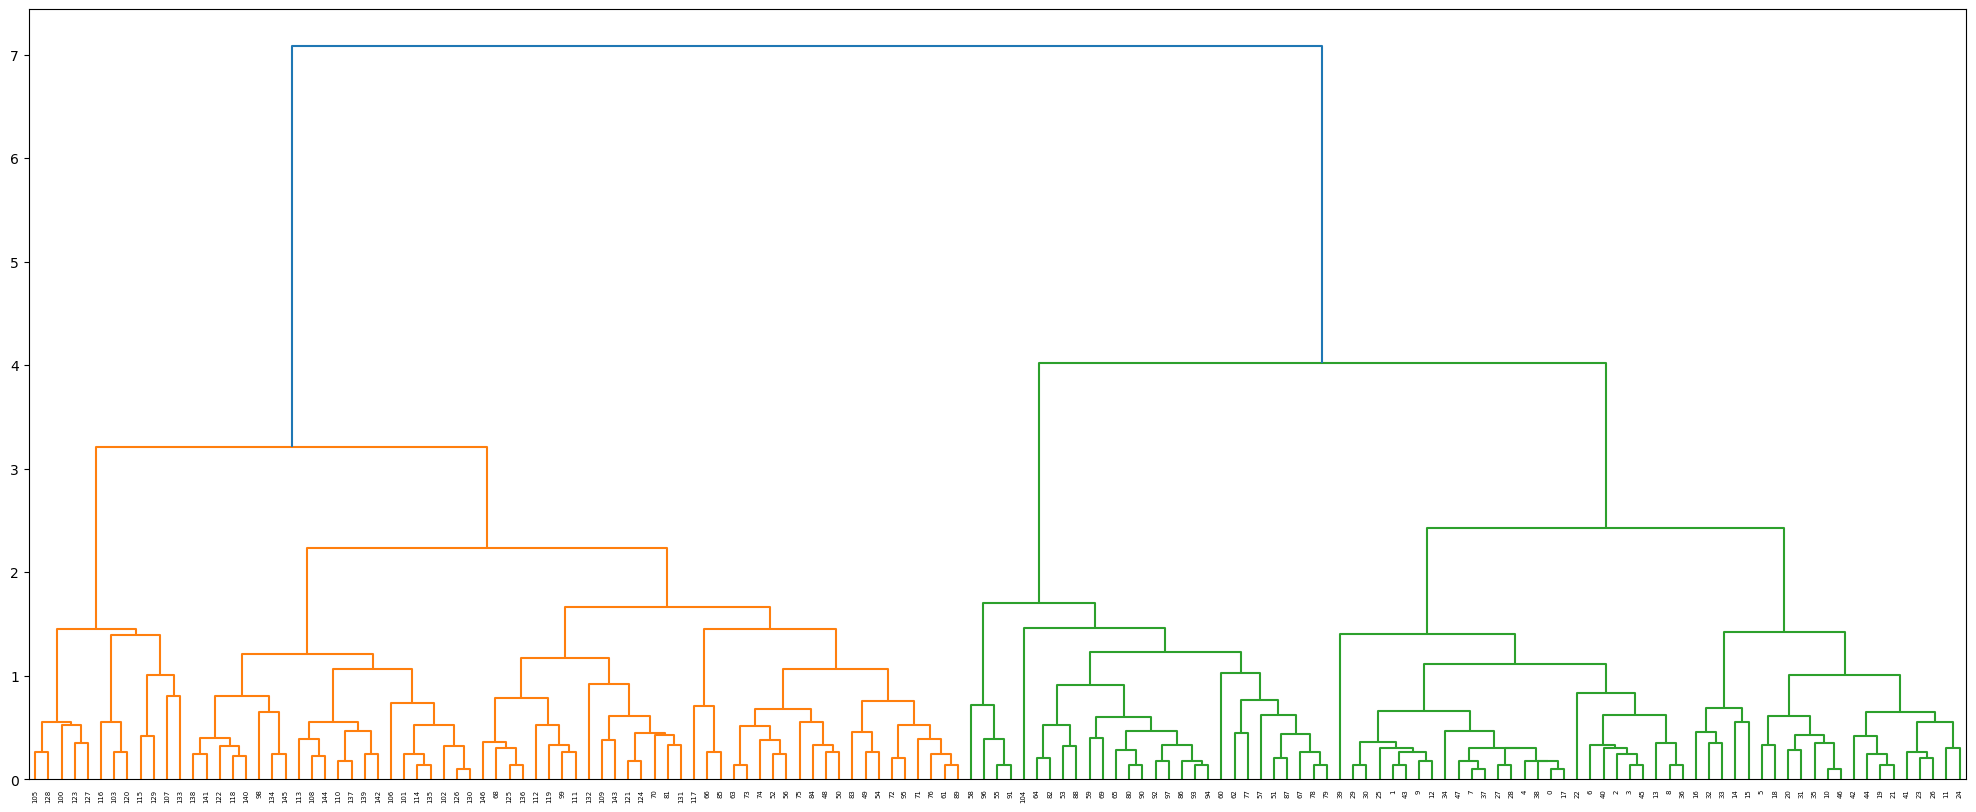

In [38]:
Z = linkage(X_iris, 'complete')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

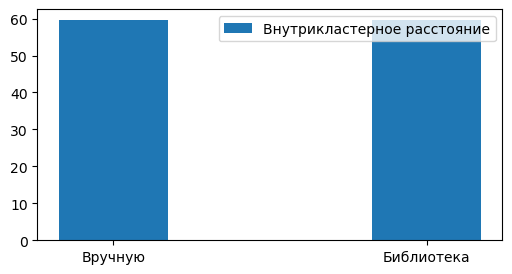

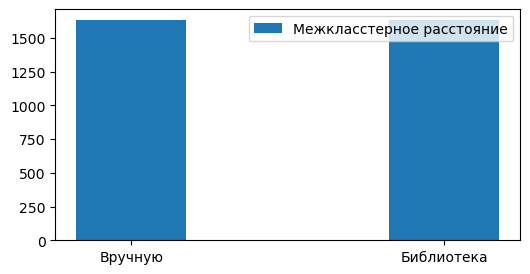

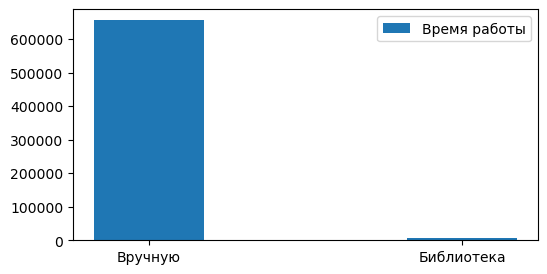

In [39]:
fig, ax = plt.subplots(figsize=(6,3))
rects1 = ax.bar(['Вручную', 'Библиотека'], [inner_ier_hand_iris_, inner_ier_lib_iris], 0.35, label='Внутрикластерное расстояние')
ax.set_xticks(['Вручную', 'Библиотека'])
ax.legend()

fig, ax = plt.subplots(figsize=(6,3))
rects2 = ax.bar(['Вручную', 'Библиотека'], [outer_ier_hand_iris_, outer_ier_lib_iris], 0.35, label='Межкласстерное расстояние')
ax.set_xticks(['Вручную', 'Библиотека'])
ax.legend()

fig, ax = plt.subplots(figsize=(6,3))
rects3 = ax.bar(['Вручную', 'Библиотека'], [time_ier_hand_iris_.microseconds, time_ier_lib_iris.microseconds], 0.35, label='Время работы')
ax.set_xticks(['Вручную', 'Библиотека'])
ax.legend()

C:\Users\makso\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\makso\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


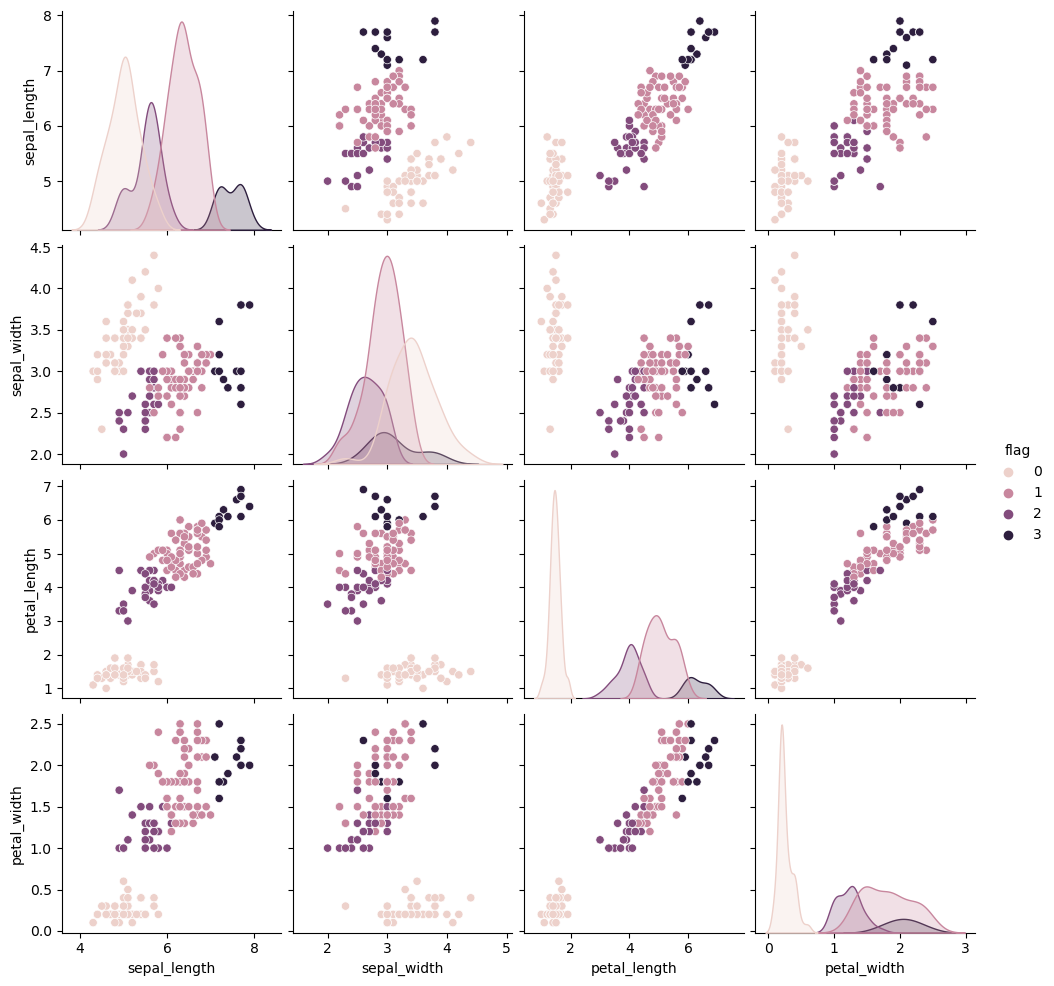

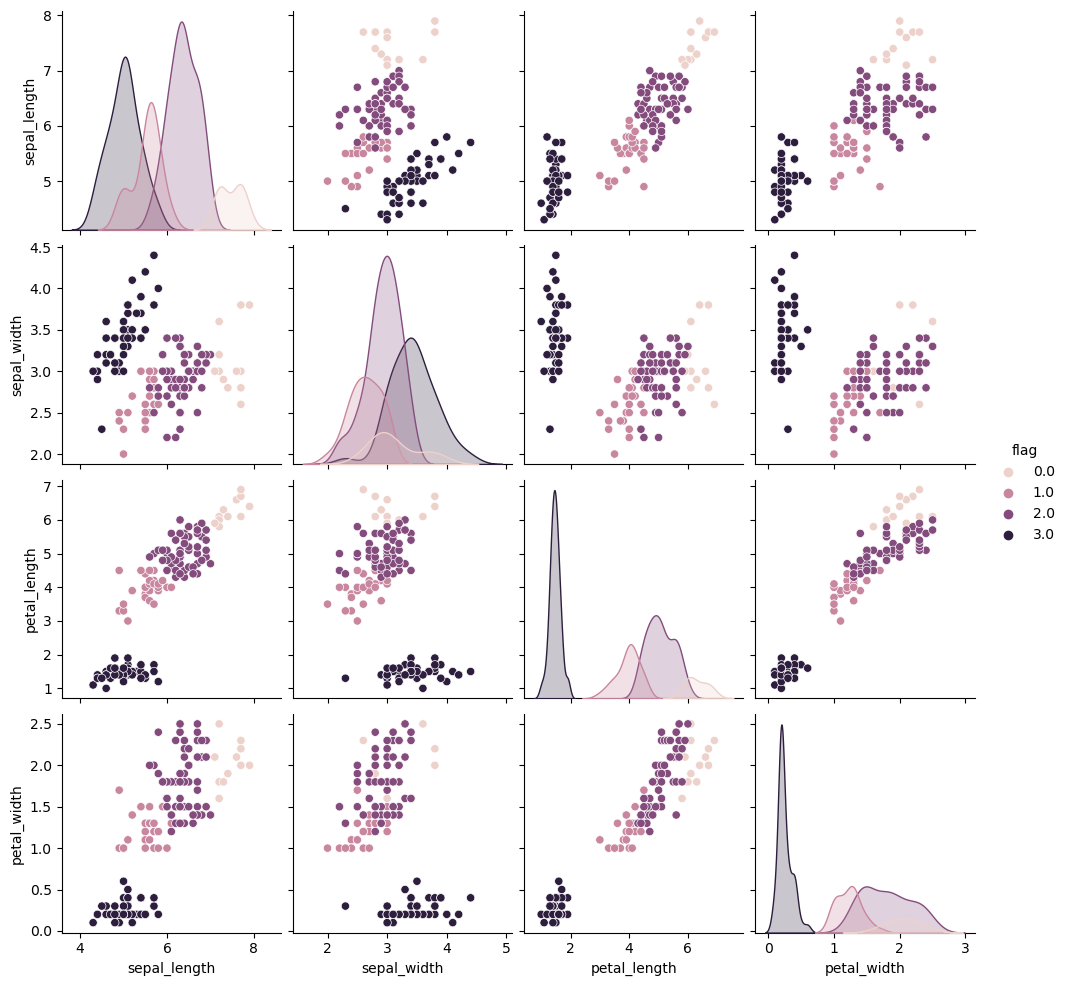

In [40]:
sns.pairplot(df_ier_iris, hue='flag')
sns.pairplot(df_ier_iris_, hue='flag')

# EM

In [41]:
def em(data, N, K, M, delta, iter_max):
    # начальные приближения
    w = [1 / K for _ in range(K)]
    m = [random.choice(data) for _ in range(K)]
    row = []
    sum_ = 0
    iter_m = 0
    for k in range(K):
        for i in range(N):
            sum_ += np.linalg.norm(np.array(data[i]) - np.array(m[iter_m]))
        iter_m += 1
        row.append(sum_ / (N * K))
    matrix = [np.diag([row[i]] * M) for i in range(K)]

    y_i = []
    iter_ = 0
    go_on = True

    while go_on is True:
        # e-шаг
        sigma = []
        matrix_1 = []
        for k in range(K):
            sigma.append(np.linalg.det(matrix[k]))

        gamma = dict()
        for k in range(K):
            gamma[k] = []

        for n in range(N):
            p_x = []
            for k in range(K):
                mat_mul = np.linalg.norm(np.array(data[n]) - np.array(m[k]))**2
                p_x_ = (np.exp(-0.5 * mat_mul) / ((2 * np.pi) ** (N / 2) * sigma[k]**0.5)) 
                p_x.append(p_x_)

            for k in range(K):
                gamma[k].append(w[k] * p_x[k] / sum([w[_] * p_x[_] for _ in range(K)]))

        # m-шаг
        w = []
        m = []
        matrix = []
        for k in range(K):
            n_k = sum(gamma[k])

            w.append(n_k / N)

            vect = []
            for j in range(M):
                mult = []
                for n in range(N):
                    mult.append(np.array(data[n])[j] * gamma[k][n])
                vect.append(sum(mult))

            m.append(np.array(vect) / (N * w[-1]))


            sigma = []
            for j in range(M):
                mult = []
                for n in range(N):
                    mult.append(gamma[k][n] * (np.array(data[n])[j] - m[k][j]) ** 2)

                sigma.append(sum(mult) / (N * w[-1]))
            matrix.append(np.diag(sigma))

        y_i_ = []
        clus = dict()
        for n in range(N):
            prob = dict()
            for k in range(K):
                prob[k] = gamma[k][n]

            max_p = max(prob.values())
            y_i_.append(max_p)

            for key, value in prob.items():
                if value == max_p:
                    clus[n] = key
                    break
        y_i.append(y_i_)

        if iter_ > 0:
            num_ = 0
            for _ in range(len(y_i_)):
                delta_ = abs(y_i[-2][_] - y_i[-1][_])
                if delta_ > delta:
                    num_ += 1
            if num_ == 0:
                go_on = False

        iter_ += 1
    return clus

## Кластеризация рыб

***Ручная кластеризация***

In [42]:
# кластеризация
time_ = datetime.datetime.now()
clust = em(cluster_df_fish, len(cluster_df_fish), 9, 2, 0.01, 100)
time__ = datetime.datetime.now()
time_em_hand_fish_ = time__ - time_

# постобработка
df_em_fish_ = X_fish.copy()
df_em_fish_['flag'] = list(clust.values())

# оценка точности прописаный алгоритм
inner_em_hand_fish_ = inner_clus(df_em_fish_, list(df_em_fish_['flag'].unique()))
outer_em_hand_fish_ = outer_clus(df_em_fish_, list(df_em_fish_['flag'].unique()))

print(f'Внутрикластерное расстояние у ем алгоритма (библиотека): {inner_em_hand_fish_}',
      f'Межкластерное расстояние у ем алгоритма (библиотека): {outer_em_hand_fish_}',
      f'Время работы у ем алгоритма (библиотека): {time_em_hand_fish_.microseconds}',
      sep='\n')

Внутрикластерное расстояние у ем алгоритма (библиотека): 197.82684520376822
Межкластерное расстояние у ем алгоритма (библиотека): 26700.917811198207
Время работы у ем алгоритма (библиотека): 660347


***Автоматическая кластеризация***

In [43]:
# кластеризация
time_ = datetime.datetime.now()
gm = GaussianMixture(n_components=9, random_state=24).fit(X_fish)
time__ = datetime.datetime.now()
time_em_lib_fish = time__ - time_

# постобработка
flag = gm.predict(X_fish)
df_em_fish = X_fish.copy()
df_em_fish['flag'] = list(flag)

# библиотечный алгоритм

inner_em_lib_fish = inner_clus(df_em_fish, list(df_em_fish['flag'].unique()))
outer_em_lib_fish = outer_clus(df_em_fish, list(df_em_fish['flag'].unique()))

print(f'Внутрикластерное расстояние у ем алгоритма (библиотека): {inner_em_lib_fish}',
      f'Межкластерное расстояние у ем алгоритма (библиотека): {outer_em_lib_fish}',
      f'Время работы у ем алгоритма (библиотека): {time_em_lib_fish.microseconds}',
      sep='\n')

C:\Users\makso\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\makso\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
C:\Users\makso\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Внутрикластерное расстояние у ем алгоритма (библиотека): 190.71909044467526
Межкластерное расстояние у ем алгоритма (библиотека): 30167.460833281806
Время работы у ем алгоритма (библиотека): 366904


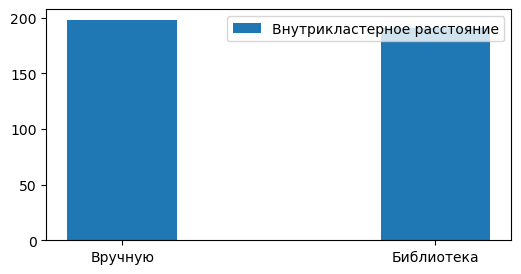

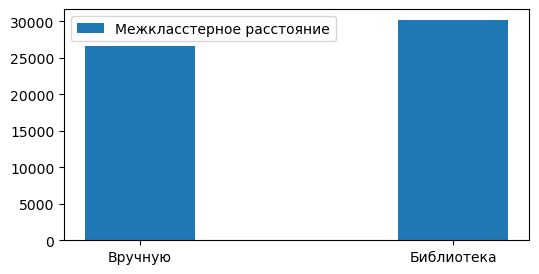

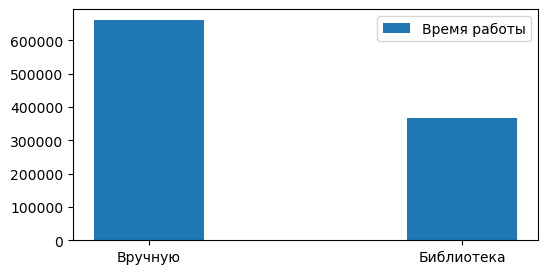

In [44]:
fig, ax = plt.subplots(figsize=(6,3))
rects1 = ax.bar(['Вручную', 'Библиотека'], [inner_em_hand_fish_, inner_em_lib_fish], 0.35, label='Внутрикластерное расстояние')
ax.set_xticks(['Вручную', 'Библиотека'])
ax.legend()

fig, ax = plt.subplots(figsize=(6,3))
rects2 = ax.bar(['Вручную', 'Библиотека'], [outer_em_hand_fish_, outer_em_lib_fish], 0.35, label='Межкласстерное расстояние')
ax.set_xticks(['Вручную', 'Библиотека'])
ax.legend()

fig, ax = plt.subplots(figsize=(6,3))
rects3 = ax.bar(['Вручную', 'Библиотека'], [time_em_hand_fish_.microseconds, time_em_lib_fish.microseconds], 0.35, label='Время работы')
ax.set_xticks(['Вручную', 'Библиотека'])
ax.legend()

C:\Users\makso\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\makso\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


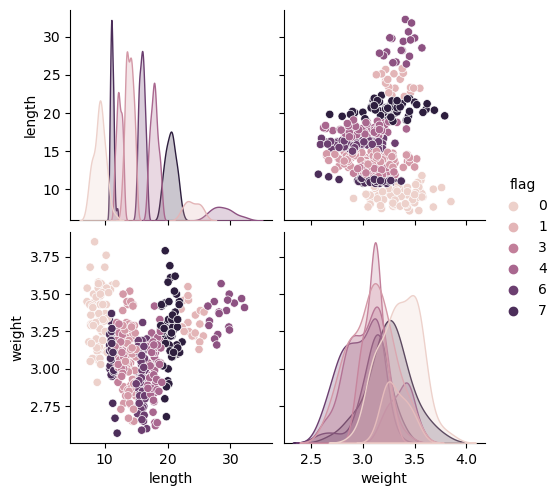

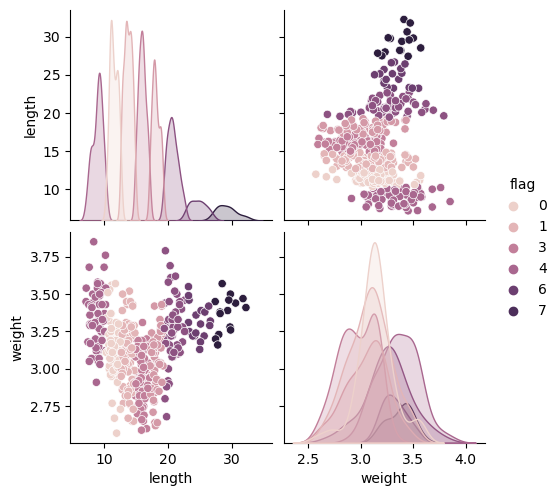

In [45]:
sns.pairplot(df_em_fish, hue='flag')
sns.pairplot(df_em_fish_, hue='flag')

## Кластеризация ириса

***Ручная кластеризация***

In [46]:
# кластеризация
time_ = datetime.datetime.now()
clust = em(cluster_df_iris, len(cluster_df_iris), 4, 4, 0.0001, 100)
time__ = datetime.datetime.now()
time_em_hand_iris_ = time__ - time_

# постобработка
df_em_iris_ = X_iris.copy()
df_em_iris_['flag'] = list(clust.values())

# оценка точности прописаный алгоритм
inner_em_hand_iris_ = inner_clus(df_em_iris_, list(df_em_iris_['flag'].unique()))
outer_em_hand_iris_ = outer_clus(df_em_iris_, list(df_em_iris_['flag'].unique()))

print(f'Внутрикластерное расстояние у ем алгоритма (библиотека): {inner_em_hand_iris_}',
      f'Межкластерное расстояние у ем алгоритма (библиотека): {outer_em_hand_iris_}',
      f'Время работы у ем алгоритма (библиотека): {time_em_hand_iris_.microseconds}',
      sep='\n')

Внутрикластерное расстояние у ем алгоритма (библиотека): 83.69131726176953
Межкластерное расстояние у ем алгоритма (библиотека): 1239.2096566264277
Время работы у ем алгоритма (библиотека): 479634


In [47]:
# кластеризация
time_ = datetime.datetime.now()
gm = GaussianMixture(n_components=4, random_state=24).fit(X_iris)
time__ = datetime.datetime.now()
time_em_lib_iris = time__ - time_

# постобработка
flag = gm.predict(X_iris)
df_em_iris = X_iris.copy()
df_em_iris['flag'] = list(flag)

# библиотечный алгоритм

inner_em_lib_iris = inner_clus(df_em_iris, list(df_em_iris['flag'].unique()))
outer_em_lib_iris = outer_clus(df_em_iris, list(df_em_iris['flag'].unique()))

print(f'Внутрикластерное расстояние у ем алгоритма (библиотека): {inner_em_lib_iris}',
      f'Межкластерное расстояние у ем алгоритма (библиотека): {outer_em_lib_iris}',
      f'Время работы у ем алгоритма (библиотека): {time_em_lib_iris.microseconds}',
      sep='\n')

C:\Users\makso\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Внутрикластерное расстояние у ем алгоритма (библиотека): 62.80122093498241
Межкластерное расстояние у ем алгоритма (библиотека): 1580.7941182579145
Время работы у ем алгоритма (библиотека): 132529


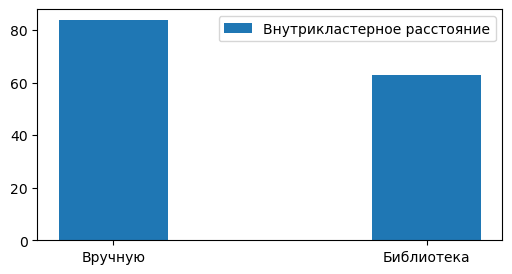

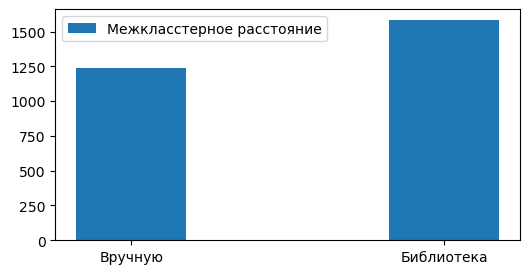

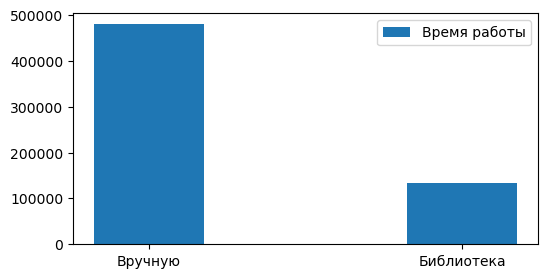

In [48]:
fig, ax = plt.subplots(figsize=(6,3))
rects1 = ax.bar(['Вручную', 'Библиотека'], [inner_em_hand_iris_, inner_em_lib_iris], 0.35, label='Внутрикластерное расстояние')
ax.set_xticks(['Вручную', 'Библиотека'])
ax.legend()

fig, ax = plt.subplots(figsize=(6,3))
rects2 = ax.bar(['Вручную', 'Библиотека'], [outer_em_hand_iris_, outer_em_lib_iris], 0.35, label='Межкласстерное расстояние')
ax.set_xticks(['Вручную', 'Библиотека'])
ax.legend()

fig, ax = plt.subplots(figsize=(6,3))
rects3 = ax.bar(['Вручную', 'Библиотека'], [time_em_hand_iris_.microseconds, time_em_lib_iris.microseconds], 0.35, label='Время работы')
ax.set_xticks(['Вручную', 'Библиотека'])
ax.legend()

C:\Users\makso\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\makso\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


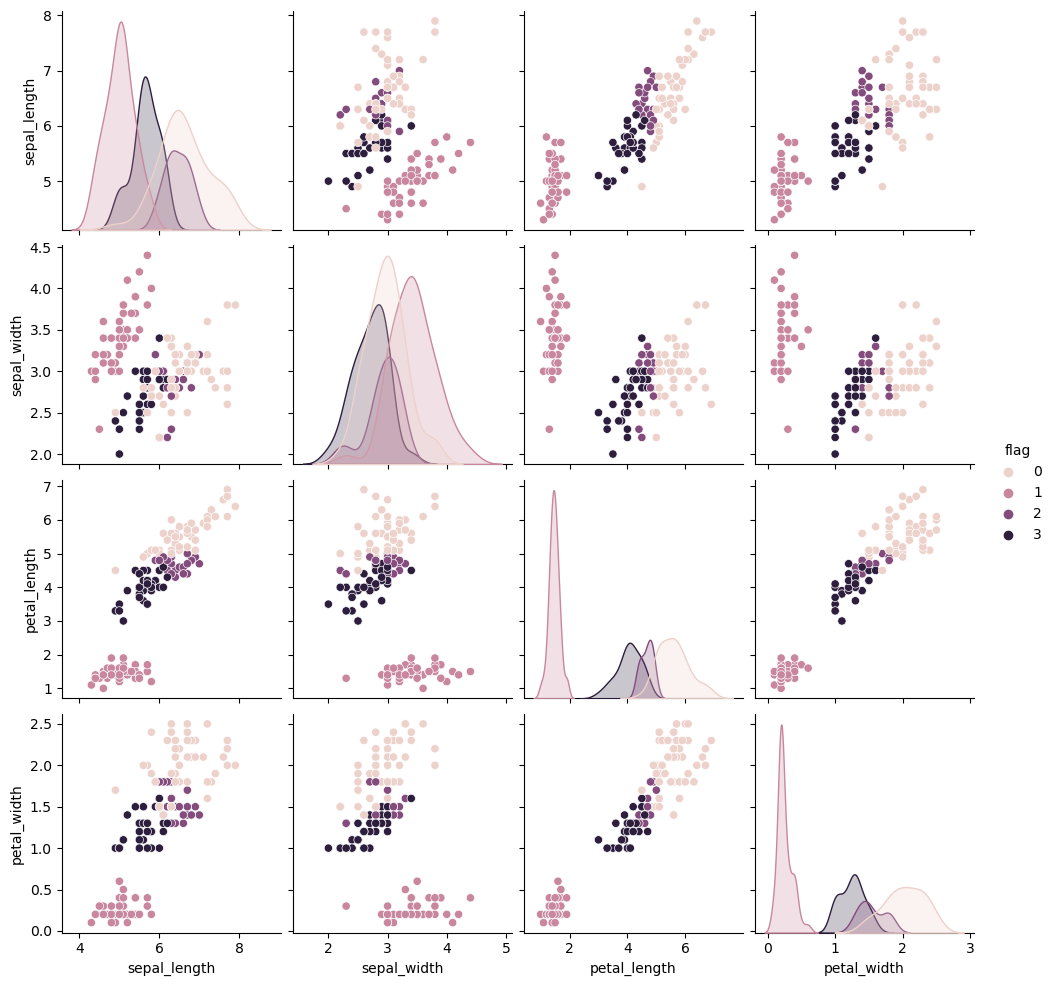

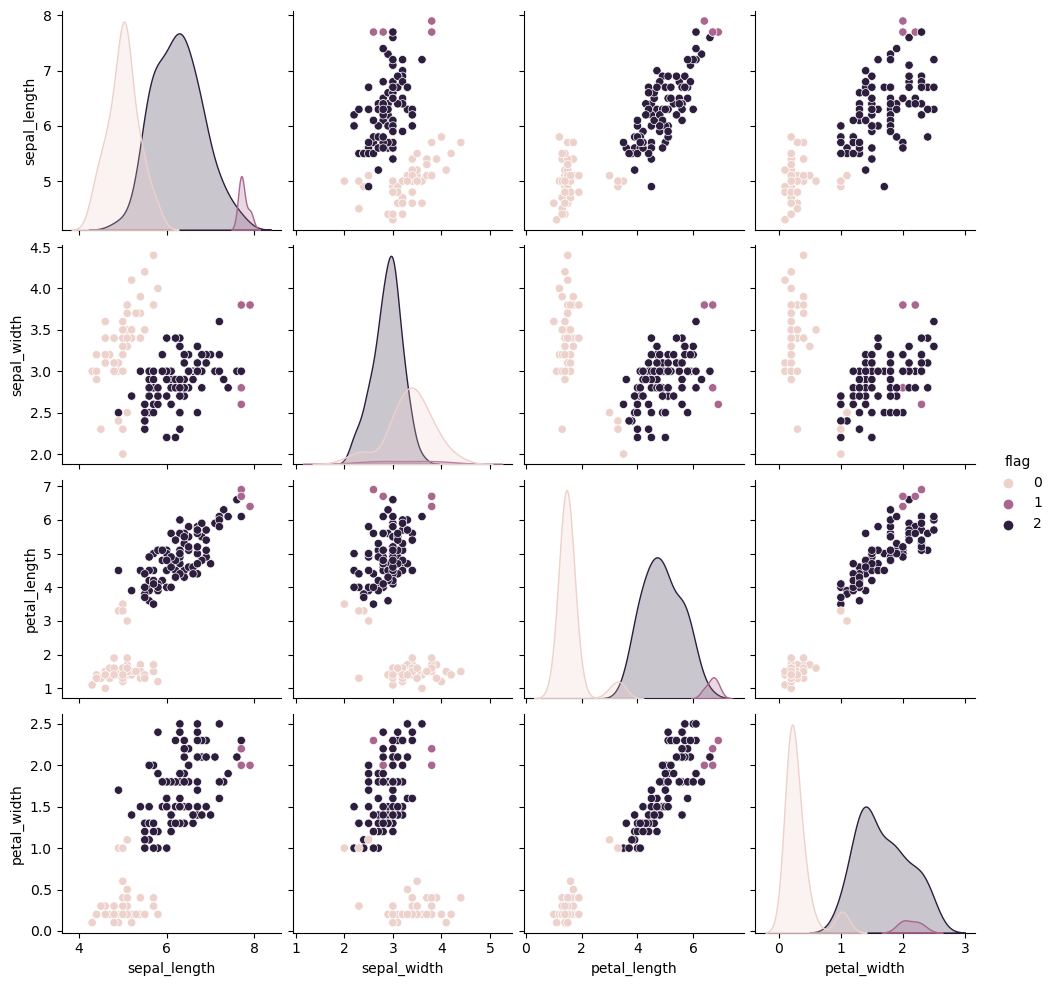

In [49]:
sns.pairplot(df_em_iris, hue='flag')
sns.pairplot(df_em_iris_, hue='flag')

# DBSCAN

In [50]:
def dbscan(data, e, m):
    maybe_noise = 0
    a = 0

    visited_points = []
    clustered_points = []
    clusters = {maybe_noise: []}

    def recur(_, neighbours):
        if a not in clusters:
            clusters[a] = []
        clusters[a].append(_)
        clustered_points.append(_)

        while neighbours:
            q = neighbours.pop()
            if q not in visited_points:
                visited_points.append(q)
                neighbours_ = [p for p in data if np.linalg.norm(np.array(q) - np.array(p)) < e]
                if len(neighbours_) > m:
                    neighbours.extend(neighbours_)
            if q not in clustered_points:
                clustered_points.append(q)
                clusters[a].append(q)
                if q in clusters[maybe_noise]:
                    clusters[maybe_noise].remove(q)

    for _ in data:
        if _ in visited_points:
            continue
        visited_points.append(_)

        neighbours = [p for p in data if np.linalg.norm(np.array(_) - np.array(p)) < e]
        if len(neighbours) < m:
            clusters[maybe_noise].append(_)
        else:
            a += 1
            recur(_, neighbours)

    return clusters

## Кластеризация рыб

***Ручная кластеризация***

In [51]:
# кластеризация
time_ = datetime.datetime.now()
clust = dbscan(cluster_df_fish, 0.2, 2)
time__ = datetime.datetime.now()
time_dbscan_hand_fish = time__ - time_

# постобработка
df_dbscan_fish = X_fish.copy().head(0)
df_dbscan_fish['flag'] = []
row_num = 0
for key, value in clust.items():
    for v in value:
        row = list(v)
        row.append(key)
        df_dbscan_fish.loc[row_num] = row
        row_num += 1

# прописаный алгоритм

inner_dbscan_hand_fish = inner_clus(df_dbscan_fish, list(df_dbscan_fish['flag'].unique()))
outer_dbscan_hand_fish = outer_clus(df_dbscan_fish, list(df_dbscan_fish['flag'].unique()))

print(f'Внутрикластерное расстояние у dbscan алгоритма (вручную): {inner_dbscan_hand_fish}',
      f'Межкластерное расстояние у dbscan алгоритма (вручную): {outer_dbscan_hand_fish}',
      f'Время работы у dbscan алгоритма (вручную): {time_dbscan_hand_fish.microseconds}',
      sep='\n')

Внутрикластерное расстояние у dbscan алгоритма (вручную): 252.35538670709948
Межкластерное расстояние у dbscan алгоритма (вручную): 226167.81805857044
Время работы у dbscan алгоритма (вручную): 161099


***Автоматическая кластеризаци***

In [52]:
# кластеризация
time_ = datetime.datetime.now()
clustering = DBSCAN(eps=0.2, min_samples=2).fit(X_fish)
flag = clustering.labels_
time__ = datetime.datetime.now()
time_dbscan_alg_fish_ = time__ - time_

# постобработка
df_dbscan_fish_ = X_fish.copy()
df_dbscan_fish_['flag'] = flag

# автоматический алгоритм
inner_dbscan_alg_fish_ = inner_clus(df_dbscan_fish_, list(df_dbscan_fish_['flag'].unique()))
outer_dbscan_alg_fish_ = outer_clus(df_dbscan_fish_, list(df_dbscan_fish_['flag'].unique()))

print(f'Внутрикластерное расстояние у dbscan алгоритма (автоматически): {inner_dbscan_alg_fish_}',
      f'Межкластерное расстояние у dbscan алгоритма (автоматически): {outer_dbscan_alg_fish_}',
      f'Время работы у dbscan алгоритма (автоматически): {time_dbscan_alg_fish_.microseconds}',
      sep='\n')

Внутрикластерное расстояние у dbscan алгоритма (автоматически): 252.6618576048874
Межкластерное расстояние у dbscan алгоритма (автоматически): 226730.48229733453
Время работы у dbscan алгоритма (автоматически): 14830


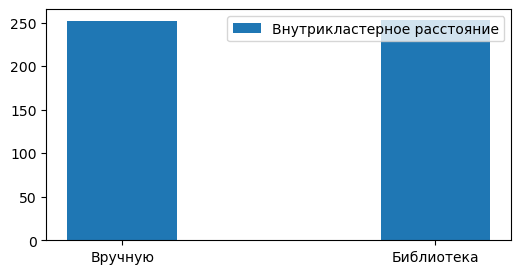

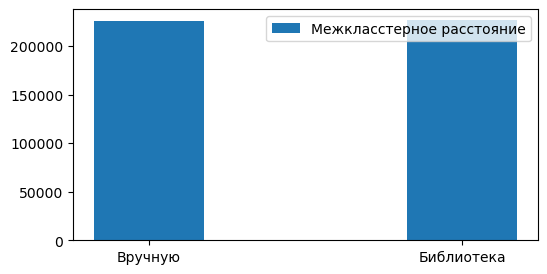

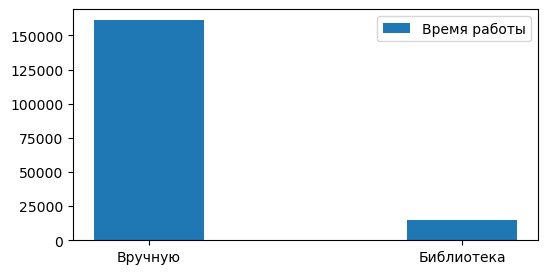

In [53]:
fig, ax = plt.subplots(figsize=(6,3))
rects1 = ax.bar(['Вручную', 'Библиотека'], [inner_dbscan_hand_fish, inner_dbscan_alg_fish_], 0.35, label='Внутрикластерное расстояние')
ax.set_xticks(['Вручную', 'Библиотека'])
ax.legend()

fig, ax = plt.subplots(figsize=(6,3))
rects2 = ax.bar(['Вручную', 'Библиотека'], [outer_dbscan_hand_fish, outer_dbscan_alg_fish_], 0.35, label='Межкласстерное расстояние')
ax.set_xticks(['Вручную', 'Библиотека'])
ax.legend()

fig, ax = plt.subplots(figsize=(6,3))
rects3 = ax.bar(['Вручную', 'Библиотека'], [time_dbscan_hand_fish.microseconds, time_dbscan_alg_fish_.microseconds], 0.35, label='Время работы')
ax.set_xticks(['Вручную', 'Библиотека'])
ax.legend()

C:\Users\makso\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\makso\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


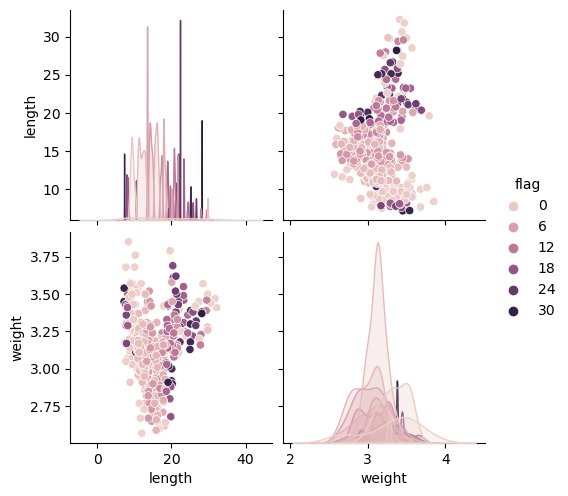

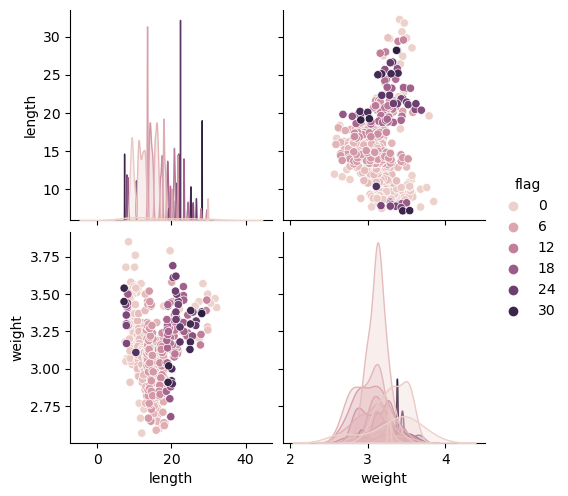

In [54]:
sns.pairplot(df_dbscan_fish_, hue='flag')
sns.pairplot(df_dbscan_fish, hue='flag')

## Кластеризация ириса

***Ручная кластеризация***

In [55]:
# кластеризация
time_ = datetime.datetime.now()
clust = dbscan(cluster_df_iris, 0.4, 2)
time__ = datetime.datetime.now()
time_dbscan_hand_iris = time__ - time_

# постобработка
df_dbscan_iris = X_iris.copy().head(0)
df_dbscan_iris['flag'] = []
row_num = 0
for key, value in clust.items():
    for v in value:
        row = list(v)
        row.append(key)
        df_dbscan_iris.loc[row_num] = row
        row_num += 1

# прописаный алгоритм

inner_dbscan_hand_iris = inner_clus(df_dbscan_iris, list(df_dbscan_iris['flag'].unique()))
outer_dbscan_hand_iris = outer_clus(df_dbscan_iris, list(df_dbscan_iris['flag'].unique()))

print(f'Внутрикластерное расстояние у dbscan алгоритма (вручную): {inner_dbscan_hand_iris}',
      f'Межкластерное расстояние у dbscan алгоритма (вручную): {outer_dbscan_hand_iris}',
      f'Время работы у dbscan алгоритма (вручную): {time_dbscan_hand_iris.microseconds}',
      sep='\n')

Внутрикластерное расстояние у dbscan алгоритма (вручную): 69.43968816357007
Межкластерное расстояние у dbscan алгоритма (вручную): 4440.966300482999
Время работы у dbscan алгоритма (вручную): 249751


In [56]:
# кластеризация
time_ = datetime.datetime.now()
clustering = DBSCAN(eps=0.4, min_samples=2).fit(X_iris)
flag = clustering.labels_
time__ = datetime.datetime.now()
time_dbscan_alg_iris_ = time__ - time_

# постобработка
df_dbscan_iris_ = X_iris.copy()
df_dbscan_iris_['flag'] = flag

# автоматический алгоритм
inner_dbscan_alg_iris_ = inner_clus(df_dbscan_iris_, list(df_dbscan_iris_['flag'].unique()))
outer_dbscan_alg_iris_ = outer_clus(df_dbscan_iris_, list(df_dbscan_iris_['flag'].unique()))

print(f'Внутрикластерное расстояние у dbscan алгоритма (автоматически): {inner_dbscan_alg_iris_}',
      f'Межкластерное расстояние у dbscan алгоритма (автоматически): {outer_dbscan_alg_iris_}',
      f'Время работы у dbscan алгоритма (автоматически): {time_dbscan_alg_iris_.microseconds}',
      sep='\n')

Внутрикластерное расстояние у dbscan алгоритма (автоматически): 69.43968816357007
Межкластерное расстояние у dbscan алгоритма (автоматически): 4440.9663004830045
Время работы у dbscan алгоритма (автоматически): 9447


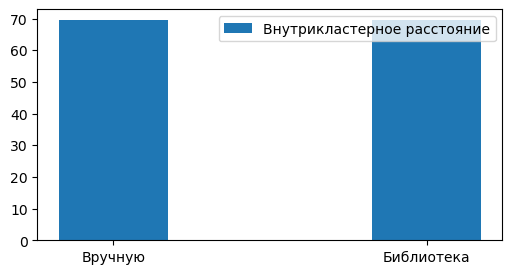

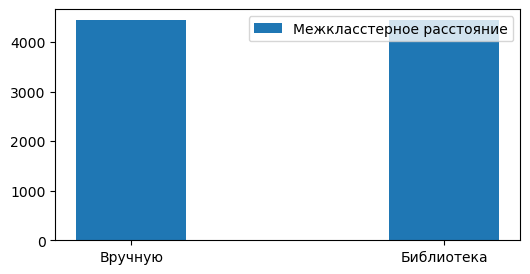

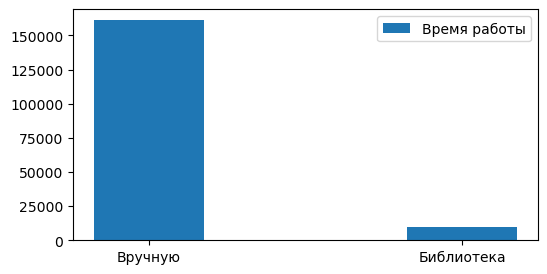

In [57]:
fig, ax = plt.subplots(figsize=(6,3))
rects1 = ax.bar(['Вручную', 'Библиотека'], [inner_dbscan_hand_iris, inner_dbscan_alg_iris_], 0.35, label='Внутрикластерное расстояние')
ax.set_xticks(['Вручную', 'Библиотека'])
ax.legend()

fig, ax = plt.subplots(figsize=(6,3))
rects2 = ax.bar(['Вручную', 'Библиотека'], [outer_dbscan_hand_iris, outer_dbscan_alg_iris_], 0.35, label='Межкласстерное расстояние')
ax.set_xticks(['Вручную', 'Библиотека'])
ax.legend()

fig, ax = plt.subplots(figsize=(6,3))
rects3 = ax.bar(['Вручную', 'Библиотека'], [time_dbscan_hand_fish.microseconds, time_dbscan_alg_iris_.microseconds], 0.35, label='Время работы')
ax.set_xticks(['Вручную', 'Библиотека'])
ax.legend()

C:\Users\makso\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\makso\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


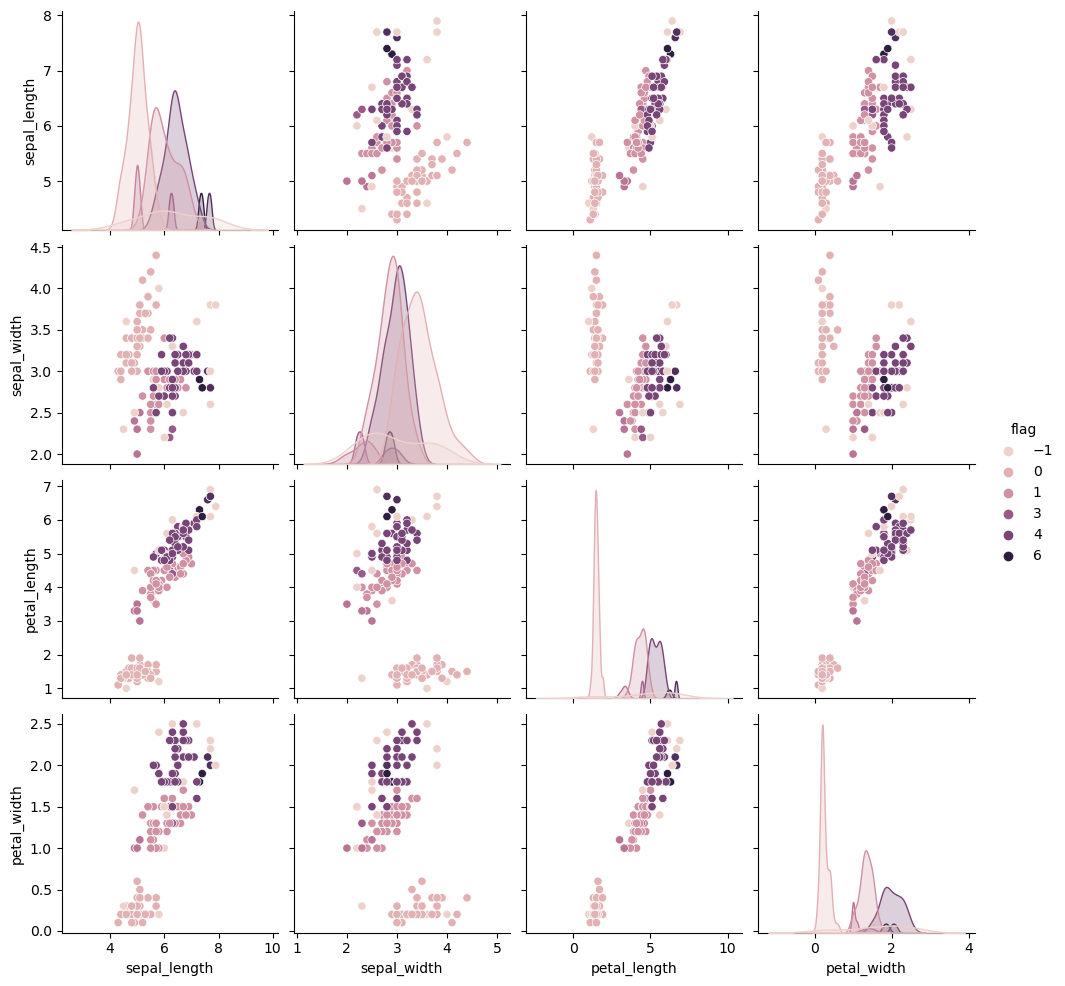

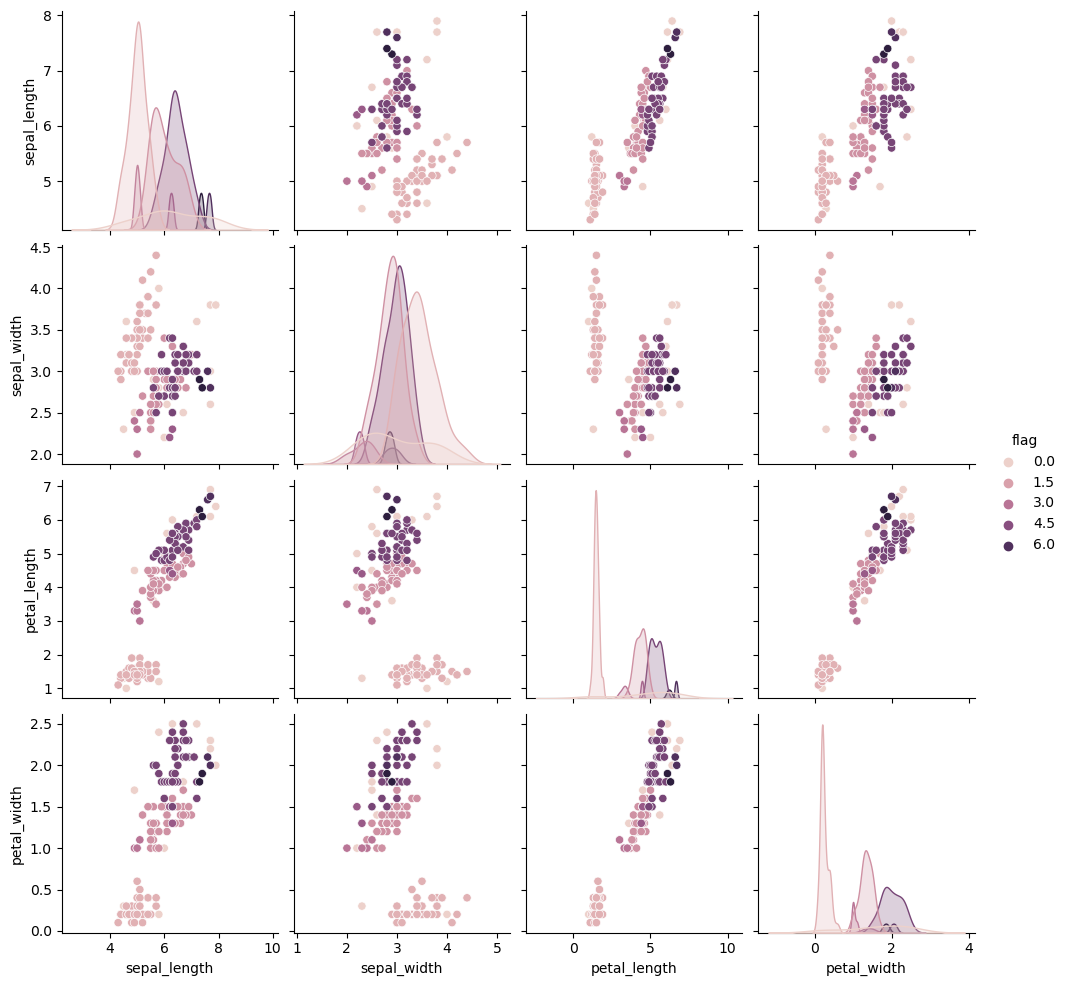

In [58]:
sns.pairplot(df_dbscan_iris_, hue='flag')
sns.pairplot(df_dbscan_iris, hue='flag')